In [3]:
# install libraries
!python -m pip install torch



  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 16.6 MB/s eta 0:00:00a 0:00:01
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.4 MB/s eta 0:00:00
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [53]:
# load libraries
# neural nets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt

# saving the model
import pickle
from datetime import datetime


In [22]:
# Step 2: Load the data (replace file paths with your actual file locations)
train_data_file = "../data/train_gesture_data.csv"
eval_data_file = "../data/eval_gesture_data.csv"
val_data_file = "../data/val_gesture_data.csv"

def load_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    y = df['label']
    X = df.drop(columns=['label'])
    
    return X, y

# Load training, evaluation, and validation data
X_train, y_train = load_data(train_data_file)
X_eval, y_eval = load_data(eval_data_file)
X_val, y_val = load_data(val_data_file)


In [28]:
X_train.describe()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,3_y,3_z,4_x,4_y,4_z,5_x,5_y,5_z,6_x,6_y,6_z,7_x,7_y,7_z,8_x,8_y,8_z,9_x,9_y,9_z,10_x,10_y,10_z,11_x,11_y,11_z,12_x,12_y,12_z,13_x,13_y,13_z,14_x,14_y,14_z,15_x,15_y,15_z,16_x,16_y,16_z,17_x,17_y,17_z,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z
count,3234.000000,3234.000000,3.234000e+03,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000,3234.000000
mean,0.568678,0.751021,1.748860e-07,0.530638,0.718732,-0.018772,0.505064,0.656073,-0.029143,0.496732,0.602200,-0.040681,0.494308,0.566575,-0.050847,0.516680,0.557054,-0.005712,0.506769,0.481766,-0.023955,0.505073,0.454524,-0.037640,0.505976,0.430397,-0.046604,0.542255,0.548649,-0.009180,0.536767,0.471983,-0.032151,0.536232,0.465526,-0.045319,0.537892,0.456267,-0.050586,0.566330,0.557810,-0.016484,0.564437,0.498533,-0.042628,0.558566,0.528228,-0.048811,0.555209,0.550687,-0.046702,0.588860,0.578092,-0.025444,0.589315,0.531148,-0.043841,0.584137,0.537965,-0.046502,0.580016,0.544613,-0.044947
std,0.212458,0.205717,3.217004e-07,0.223295,0.203338,0.016469,0.238268,0.202225,0.024660,0.254940,0.204956,0.030881,0.268062,0.208947,0.037510,0.243067,0.186785,0.025687,0.261947,0.190736,0.033322,0.271887,0.201662,0.037649,0.280170,0.217872,0.040906,0.246715,0.187211,0.023515,0.269977,0.193571,0.034759,0.277630,0.209940,0.036795,0.281773,0.231299,0.036852,0.247289,0.192725,0.023514,0.269778,0.202132,0.033754,0.270136,0.212692,0.031580,0.266302,0.221950,0.030372,0.246316,0.202874,0.026144,0.264355,0.212026,0.032848,0.266916,0.222634,0.031370,0.265278,0.233403,0.030588
min,0.108650,0.239104,-8.340000e-07,0.038115,0.219018,-0.103124,-0.028035,0.154324,-0.163064,-0.084128,0.093993,-0.209292,-0.122867,0.084002,-0.252329,-0.027657,0.111062,-0.119668,-0.074377,0.067525,-0.182001,-0.108298,0.042380,-0.221803,-0.134002,0.001718,-0.246706,-0.000154,0.109439,-0.112412,-0.051173,0.056082,-0.198633,-0.090383,0.030291,-0.217956,-0.118983,-0.028268,-0.230744,0.031278,0.109970,-0.123594,-0.020027,0.056449,-0.203965,-0.047098,0.102551,-0.190766,-0.071222,0.055780,-0.168058,0.067340,0.112530,-0.145435,0.031199,0.073496,-0.193642,0.003024,0.083440,-0.175617,-0.022591,0.023301,-0.190563
25%,0.374997,0.601639,-7.500000e-08,0.323513,0.565207,-0.027172,0.280850,0.495443,-0.042416,0.256778,0.437821,-0.058279,0.240458,0.404115,-0.073502,0.285486,0.406437,-0.019147,0.254780,0.320600,-0.042440,0.244424,0.285834,-0.059664,0.240180,0.246061,-0.070656,0.308574,0.399127,-0.023363,0.277817,0.313956,-0.052716,0.273075,0.300316,-0.067836,0.275291,0.279439,-0.073388,0.333129,0.404618,-0.030880,0.308070,0.336065,-0.064064,0.303319,0.356466,-0.069439,0.301977,0.367975,-0.065195,0.360095,0.416855,-0.039971,0.336644,0.360183,-0.064449,0.330183,0.358961,-0.066644,0.330344,0.350680,-0.062675
50%,0.610121,0.773110,2.387799e-07,0.573194,0.738698,-0.017120,0.545034,0.669053,-0.025786,0.536187,0.614229,-0.035283,0.531287,0.572457,-0.043713,0.556185,0.564524,-0.004679,0.543543,0.478027,-0.020001,0.539659,0.449450,-0.032821,0.539240,0.428157,-0.041325,0.584258,0.554567,-0.007880,0.579855,0.467179,-0.025706,0.577397,0.469817,-0.039625,0.580864,0.469948,-0.046701,0.608433,0.566034,-0.015110,0.612738,0.495438,-0.037424,0.607157,0.534259,-0.046724,0.601385,0.556076,-0.046897,0.632396,0.581461,-0.024405,0.636399,0.529159,-0.041700,0.632881,0.541964,-0.045540,0.625

In [36]:
labels ={
    0: "no_gesture",                    # nothing_detected
    1: "track_mouse_pointer",           # index_finger_up
    2: "select_objects_using_mouse",    # index_and_thumb_up
    3: "prepare_for_left_click",        # index_and_middle_spaced
    4: "execute_left_click",            # index_and_middle_together
    5: "prepare_for_right_click",       # index_thumb_middle_spaced
    6: "execute_right_click"            # index_thumb_middle_together
}

In [27]:
# # testing for data consistency
# gesture_eval = y_eval.map(labels)
# gesture_eval.value_counts()

In [32]:
# 3: normalizing the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_eval_norm = scaler.fit_transform(X_eval)
X_val_norm = scaler.fit_transform(X_val)

# pd.DataFrame(X_train_norm).describe()

In [ ]:
# 4: convert data to pytorch tensor
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_eval_tensor = torch.tensor(X_eval_norm, dtype=torch.float32)
y_eval_tensor = torch.tensor(y_eval.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [35]:
# 5: creating Dataloader fro batching the data
## creating dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# creating batch loader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



In [ ]:
# 6: defining neural network architecture
class GestureNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes) -> None:
        super(GestureNet, self).__init__()
        self.network_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),                               # 63 -> 128
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),                         # bath norm for better convergence
            nn.Dropout(0.3),                                                # prevent overfitting
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes)      # 128 -> 7
        )
    
    def forward(self, x):
        logits = self.network_stack(x)
        return logits
        

In [42]:
# 7: setup device
if torch.cuda.is_available():
    device = torch.device("cuda")       # use NVIDIA GPU if available
    print("Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")        # use Apple GPU if available
    print("Using device: MPS")
else:
    device = torch.device("cpu")        # fallback to CPU
    print("Using device: CPU")

    

Using device: MPS


In [43]:
# 8: Model Training:
## training (70% of total) + evaluation architecture (10% of total)  = (80% of total)

# hyper-parameters
input_size = 63
hidden_size = 128
num_classes = 7
epochs = 20
learning_rate = 1e-2

# model
model = GestureNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [46]:
# training and validation loop
## for plotting
train_losses = []
validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    ##### TRAINING LOOP #####
    
    # setting model to training mode
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # update global parameters
    epoch_train_loss /= len(train_loader)           # avg loss per epoch
    train_losses.append(epoch_train_loss)
    
    ##### VALIDATION LOOP #####
    model.eval()
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
            
            # computing accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        
    # update global parameters
    epoch_val_loss /=len(val_loader)            # avg loss per epoch
    validation_losses.append(epoch_val_loss)
    
    val_accuracy = correct / total
    validation_accuracies.append(val_accuracy)
    
    # printout progress
    print(f"+------------------------------------+")
    print(f"| Epoch [{epoch+1}/{epochs}]")
    print(f"| Train Loss: {epoch_train_loss:.4f}")
    print(f"| Validation Loss: {epoch_val_loss:.4f}")
    print(f"| validation Accuracy: {val_accuracy:.4f}")
    print(f"+------------------------------------+")

print("====================================\n########## TRAINING COMPLETE #########")
    
    
        
            
        

+------------------------------------+
| Epoch [1/20]
| Train Loss: 0.7324
| Validation Loss: 0.5151
| validation Accuracy: 0.7983
+------------------------------------+
+------------------------------------+
| Epoch [2/20]
| Train Loss: 0.6277
| Validation Loss: 0.3882
| validation Accuracy: 0.8573
+------------------------------------+
+------------------------------------+
| Epoch [3/20]
| Train Loss: 0.6103
| Validation Loss: 0.4120
| validation Accuracy: 0.8458
+------------------------------------+
+------------------------------------+
| Epoch [4/20]
| Train Loss: 0.4919
| Validation Loss: 0.2985
| validation Accuracy: 0.8818
+------------------------------------+
+------------------------------------+
| Epoch [5/20]
| Train Loss: 0.4831
| Validation Loss: 0.2193
| validation Accuracy: 0.9207
+------------------------------------+
+------------------------------------+
| Epoch [6/20]
| Train Loss: 0.4510
| Validation Loss: 0.2008
| validation Accuracy: 0.9438
+------------------

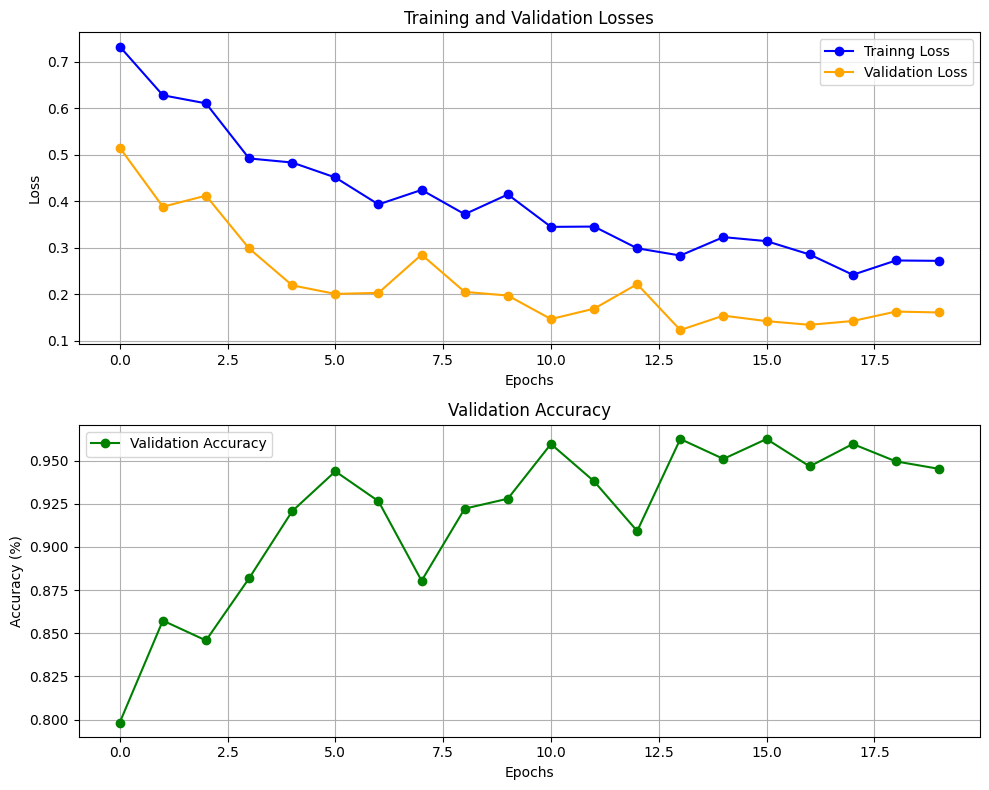

In [50]:
# plotting the losses and accuracies

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# a: plotting losses
axs[0].plot(train_losses, label='Trainng Loss', marker='o', color='blue')
axs[0].plot(validation_losses, label='Validation Loss', marker='o', color='orange')
axs[0].set_title('Training and Validation Losses')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)


# b: plotting validation accuracies
axs[1].plot(validation_accuracies, label='Validation Accuracy', marker='o', color='green')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True)

# adjust layout and show plots
plt.tight_layout()
plt.show()

In [52]:
# 9: EVALUATION
model.eval()
test_loss = 0.0
correct= 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in eval_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        # computeing accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

test_loss /= len(eval_loader)
test_accuracy = correct / total

print(f"+------------------------------------+")
print(f"| Test Loss: {test_loss:.4f}")
print(f"| Test Accuracy: {test_accuracy:.4f}")
print(f"+------------------------------------+")


+------------------------------------+
| Test Loss: 0.2074
| Test Accuracy: 0.9336
+------------------------------------+


In [56]:
# 10: Saving the current model

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")        # format: YYYYMMDD_HHMMSS
# print(timestamp)

checkpoint_path = f"../checkpoints/model_gesture_recog_{timestamp}.pth"

# save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),          # for further improvement instance (future proofing :)
    'epochs_trained' : epochs 
}, checkpoint_path)

print(f"Checkpoint saved @: {checkpoint_path}")


Checkpoint saved @: ../checkpoints/model_gesture_recog_20241203_164311.pth


In [ ]:
pickle_path = "../checkpoints/pickles/model_gesture_recog.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(model, f)